<a href="https://colab.research.google.com/github/amartya-mitra/LOLA-pytorch/blob/master/toy_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install packages:

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

## Generating a latent data distribution
- Generate a set of binary labels +1 and -1 with equal probability
- Generate a core feature from a Gaussian distribution with mean $mu*y$ and variance $1$
- Generate a new spurious feature that is highly correlated with the target label y
- Generate additional noise dimensions equal to the sample size
- Combine all

In [26]:
# Accepts hyper-parameters describing the data distribution and returns
# the tuple (features, labels)

def get_toy_data(n_samples, feature_dict, seed, dim_noise=0, extra_dims_norm=0):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  # print(f"Using seed: {seed}")

  # Generate binary labels with equal probability
  y = torch.randint(0, 2, (n_samples,)) * 2 - 1

  # Generate a core feature from a Gaussian distribution
  # The mean of the feature is y * mu and variance is 1
  feature_c = feature_dict['core_multiplier'] * (y * feature_dict['mu'] + feature_dict['sigma'] * torch.randn(n_samples))

  # Generate a new spurious feature to the existing setup
  flip_prob = torch.rand(n_samples)
  feature_s = torch.where(flip_prob < feature_dict['p'], y, -y).float()
  if True:
    feature_s += feature_dict['spurious_multiplier'] * torch.randn(n_samples)


  # Combine the original feature and the new feature into a single dataset
  features = torch.stack((feature_c, feature_s), dim=1)

  # Add additional noise dimensions
  noise = np.random.randn(n_samples, dim_noise)
  noise = noise / np.linalg.norm(noise, 2, 1, keepdims=True)
  noise = feature_dict['noise_multiplier'] * noise

  X = torch.cat([features, torch.tensor(noise)], 1)

  return X, y

# Number of samples
n_samples = 2000
# Fixed value for mu
mu, sigma = 2.0, 0.5
# Probability of flipping
p = 0.99
# Core feature strength
core_multiplier = 0.07 # 0.9
# Spurious feature strength
spurious_multiplier = 0.1
# seed
seed = 2
# noise dim
noise_dim = 5
# Noise strength
noise_multiplier = 0.001

feature_dict = {'mu': mu,
                'sigma': sigma,
                'p': p,
                'spurious_multiplier': spurious_multiplier,
                'core_multiplier': core_multiplier,
                'noise_multiplier': noise_multiplier}
X, y = get_toy_data(n_samples, feature_dict, seed, noise_dim)

## Plot the toy data

In [28]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
import torch

# Convert to NumPy arrays for Bokeh
features_np = X[:,:2].numpy()
target_np = y.numpy()

# Create a ColumnDataSource
source = ColumnDataSource(data=dict(
    x=features_np[:, 0],
    y=features_np[:, 1],
    color=['blue' if t == 1 else 'red' for t in target_np]
))

# Create a Bokeh plot
p = figure(title="2D Plot of Features", x_axis_label='Core Feature', y_axis_label='Spurious Feature')
p.scatter(x='x', y='y', color='color', source=source)

# Output inline in Jupyter Notebook
output_notebook()

# Show the plot
show(p)

## Define the model

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

# Defining the binary classifier model
class Classifier(nn.Module):
    def __init__(self, input_dim, n_layer, hidden_dim):
        super(Classifier, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim)])  # First layer

        # Adding hidden layers
        for _ in range(n_layer - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        x = torch.sigmoid(self.output(x))
        return x

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, num_hidden_layers, hidden_layer_width, activation_func):
        super(BinaryClassifier, self).__init__()

        # Create a list to hold the layers
        layers = []

        # Add the first hidden layer
        layers.append(nn.Linear(input_dim, hidden_layer_width))

        # Add the chosen activation function
        if activation_func == 'relu':
            layers.append(nn.ReLU())
        elif activation_func == 'tanh':
            layers.append(nn.Tanh())
        elif activation_func == 'sigmoid':
            layers.append(nn.Sigmoid())
        elif activation_func == 'linear':
            pass
        else:
            raise ValueError("Unsupported activation function")

        # Add subsequent hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_layer_width, hidden_layer_width))
            if activation_func == 'relu':
                layers.append(nn.ReLU())
            elif activation_func == 'tanh':
                layers.append(nn.Tanh())
            elif activation_func == 'sigmoid':
                layers.append(nn.Sigmoid())

        # Add the output layer
        layers.append(nn.Linear(hidden_layer_width, 1))
        layers.append(nn.Sigmoid())  # Assuming binary classification

        # Combine all layers into a Sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Define the training loop and train the model
- Activation Function options: `relu`, `linear`, `tanh` and `sigmoid`.

Epoch [100/400], Loss: 0.0322
Epoch [200/400], Loss: 0.0002
Epoch [300/400], Loss: 0.0001
Early stopping triggered at epoch 311 with loss 0.0001


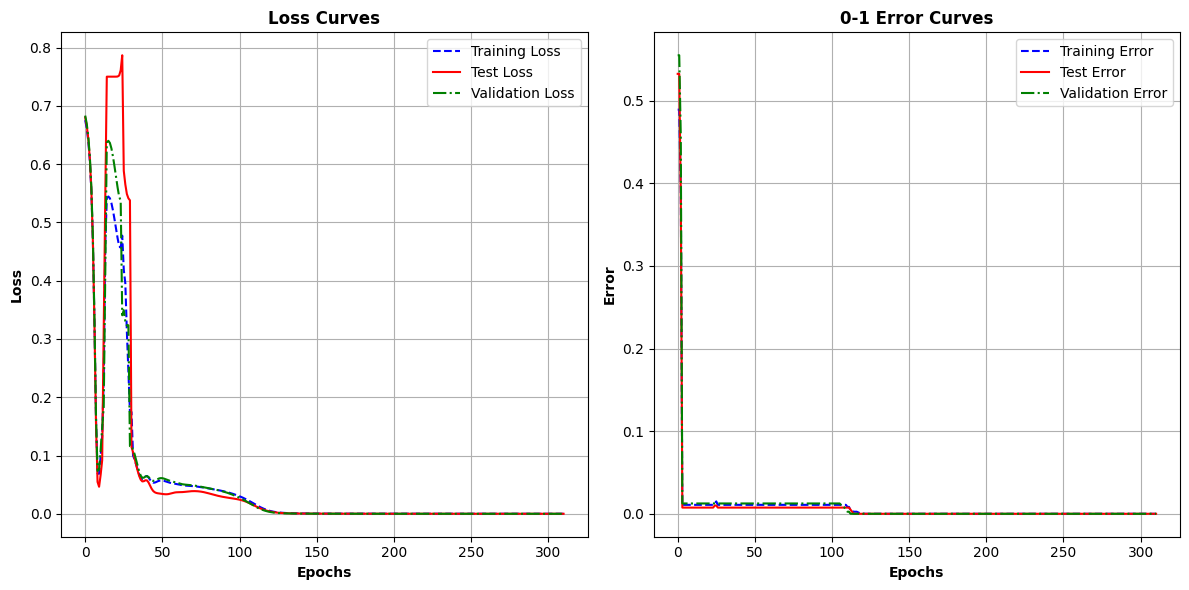

In [34]:
def plot_metrics(train_losses, test_losses, val_losses, train_errors, test_errors, val_errors):
  # Set modern style for plot elements
  plt.style.use("seaborn-v0_8-pastel")  # Or choose a different style you prefer

  plt.figure(figsize=(12, 6))  # Adjust figure size as needed

  # Loss Curves
  ax1 = plt.subplot(121)
  ax1.plot(train_losses, label='Training Loss', linestyle='--', color='blue')
  ax1.plot(test_losses, label='Test Loss', linestyle='-', color='red')
  ax1.plot(val_losses, label='Validation Loss', linestyle='-.', color='green')
  ax1.set_xlabel('Epochs', fontweight='bold')
  ax1.set_ylabel('Loss', fontweight='bold')
  ax1.set_title('Loss Curves', fontweight='bold')
  ax1.grid(True)
  ax1.legend()

  # Error Curves
  ax2 = plt.subplot(122)
  ax2.plot(train_errors, label='Training Error', linestyle='--', color='blue')
  ax2.plot(test_errors, label='Test Error', linestyle='-', color='red')
  ax2.plot(val_errors, label='Validation Error', linestyle='-.', color='green')
  ax2.set_xlabel('Epochs', fontweight='bold')
  ax2.set_ylabel('Error', fontweight='bold')
  ax2.set_title('0-1 Error Curves', fontweight='bold')
  ax2.grid(True)
  ax2.legend()

  plt.tight_layout()  # Adjust spacing between subplots
  plt.show()

def train_model(model, epochs, use_es, train_dict, inputs, target):

  # Early stopping parameters
  no_improve_epochs = 0
  min_loss_change = train_dict['min_loss_change']  # Define 'substantial' change here
  no_improve_threshold = train_dict['no_improve_threshold']  # Stop if no improvement in 5 epochs
  best_loss = float('inf')

  # Binary Cross Entropy Loss for binary classification
  criterion = nn.BCELoss()

  # Optimizer
  optimizer = optim.SGD(model.parameters(),
                        lr=train_dict['lr'],
                        momentum=train_dict['momentum'])

  # For plotting metrics
  train_losses, test_losses, val_losses = [], [], []
  train_errors, test_errors, val_errors = [], [], []

  train_size = math.floor(len(inputs)*0.6)
  test_size = math.floor(len(inputs)*0.2)
  val_size = len(inputs) - train_size - test_size

  X_train, y_train = inputs[:train_size], target[:train_size]
  X_test, y_test = inputs[train_size:train_size+test_size], target[train_size:train_size+test_size]
  X_val, y_val = inputs[train_size+test_size:], target[train_size+test_size:]

  for epoch in range(epochs):
      # Zero the parameter gradients
      model.train()
      optimizer.zero_grad()
      running_loss = 0.0

      # Forward pass
      outputs = model(X_train)
      loss = train_dict['loss_mp'] * criterion(outputs, (y_train + 1)/2)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      ############## Compute Metrics ################
      train_outputs = model(X_train)
      train_loss = train_dict['loss_mp'] * criterion(train_outputs, (y_train + 1)/2)
      train_predictions = torch.round(train_outputs)  # Convert probabilities to 0/1 predictions
      train_error = torch.mean((train_predictions != (y_train + 1)/2).float())

      test_outputs = model(X_test)
      test_loss = train_dict['loss_mp'] * criterion(test_outputs, (y_test + 1)/2)
      test_predictions = torch.round(test_outputs)  # Convert probabilities to 0/1 predictions
      test_error = torch.mean((test_predictions != (y_test + 1)/2).float())

      val_outputs = model(X_val)
      val_loss = train_dict['loss_mp'] * criterion(val_outputs, (y_val + 1)/2)
      val_predictions = torch.round(val_outputs)  # Convert probabilities to 0/1 predictions
      val_error = torch.mean((val_predictions != (y_val + 1)/2).float())

      ################## Append Metrics ###############

      train_losses.append(train_loss.item())
      train_errors.append(train_error.item())

      test_losses.append(test_loss.item())
      test_errors.append(test_error.item())

      val_losses.append(val_loss.item())
      val_errors.append(val_error.item())

      if use_es:

        # Average loss for this epoch
        running_loss += loss.item()
        epoch_loss = running_loss

        # Check for improvement
        if best_loss - epoch_loss > min_loss_change:
            no_improve_epochs = 0
            best_loss = epoch_loss
        else:
            no_improve_epochs += 1

        # Early stopping check
        if no_improve_epochs >= no_improve_threshold:
            print(f'Early stopping triggered at epoch {epoch+1} with loss {epoch_loss:.4f}')
            break

      # Print loss every 10 epochs
      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

  # Plot the metrics
  plot_metrics(train_losses, test_losses, val_losses, train_errors, test_errors, val_errors)

  # The model is now trained on the dataset with two features
  # and the associated binary labels using a single output node and BCE loss
  return model

epochs = 400
lr = 0.1
momentum = 0.9
min_loss_change = 0.0001
no_improve_threshold = 100
use_es = True
loss_mp = 1
activation_func = 'linear'

train_dict = {'epochs': epochs,
              'min_loss_change': min_loss_change,
              'no_improve_threshold': no_improve_threshold,
              'use_es': use_es,
              'lr': lr,
              'momentum': momentum,
              'loss_mp': loss_mp}

n_layer = 5  # Number of layers
hidden_dim = 100  # Hidden layer dimension
input_dim = X.shape[1]
X = X.to(torch.float32)

# Creating the model instance
model = BinaryClassifier(input_dim, n_layer, hidden_dim, activation_func)
model = train_model(model, epochs, use_es, train_dict, X, y.float().view(-1, 1))

## Plot the decision boundary

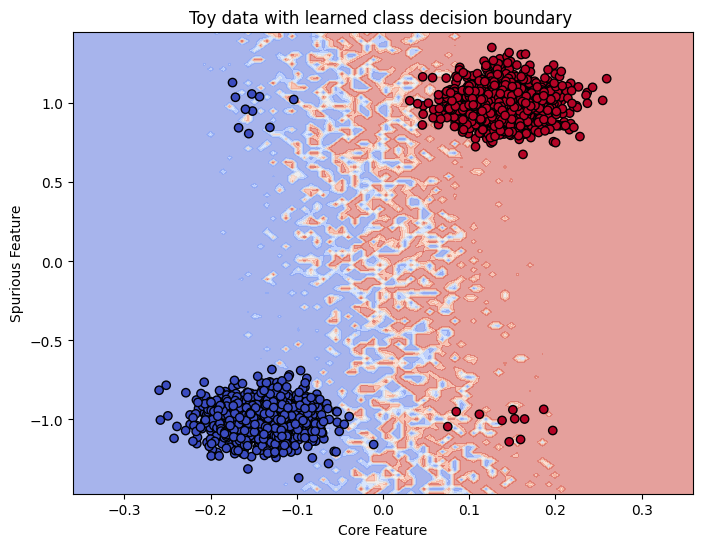

In [35]:
def toy_plot(model, data, y, seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

  features = data[:, :2].numpy()  # Assuming data is a 2D Torch Tensor
  labels = y.numpy()  # Assuming labels are in the third column

  x_min, x_max = features[:, 0].min() - 0.1, features[:, 0].max() + 0.1
  y_min, y_max = features[:, 1].min() - 0.1, features[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
  grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

  if data.shape[1] > 2:
    # Add noise to the grid
    noise = np.random.randn(grid.shape[0], data.shape[1] - 2)
    noise = noise / np.linalg.norm(noise, 2, 1, keepdims=True)
    grid = torch.cat([grid, torch.tensor(noise)], 1)

  with torch.no_grad():
    z = model(grid.to(torch.float32)).numpy().reshape(xx.shape)  # Predict scores on the grid

  plt.figure(figsize=(8, 6))

  # Plot the decision boundary with a color gradient
  plt.contourf(xx, yy, z, cmap='coolwarm', alpha=0.5)  # Adjust alpha for transparency

  # Plot the data points with appropriate colors
  plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='coolwarm', edgecolors='k')

  # Add labels and title
  plt.xlabel("Core Feature")
  plt.ylabel("Spurious Feature")
  plt.title("Toy data with learned class decision boundary ")

  plt.show()

toy_plot(model, X, y, seed)

Observation:
- Increasing the noise dimensions increases the tendency of the model to memorize the minority samples, and using the spurious feature(s) with greater effect
- Regulating the strength of the core feature(s) determines the ability of the model to learn the same
- `ReLU` and `Linear` activations behave similarly


## Computing layerwise rank of the trained model
- Extracting the (trained) layer weights and computing their soft rank
- Computing the rank of the combined weight matrices (http://arxiv.org/abs/2103.10427)
- Extracting the (trained) layer representations and computing their soft rank (http://arxiv.org/abs/2305.19753)

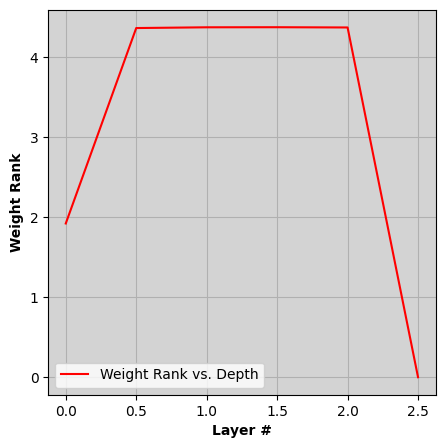

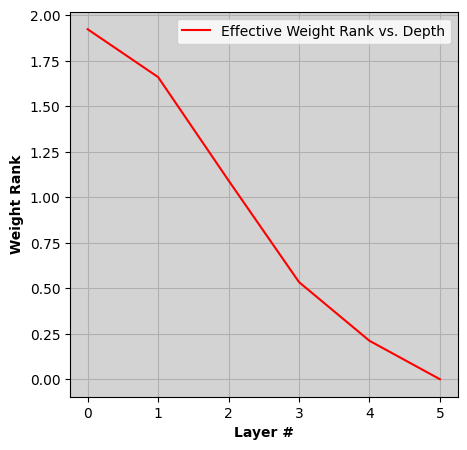

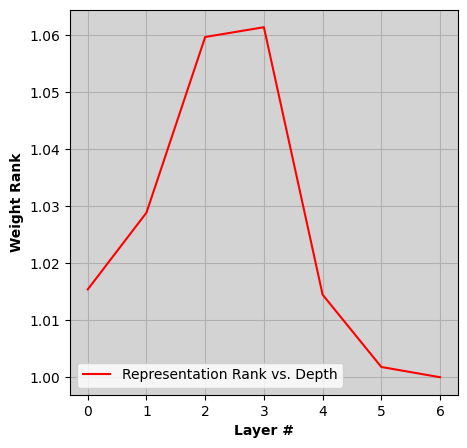

In [36]:

def plot_rank(se, le, label):
  # Set modern style for plot elements
  plt.style.use("seaborn-v0_8-pastel")  # Or choose a different style you prefer

  # Create the plot
  plt.figure(figsize=(5, 5))

  # Plot the curves with different line styles and colors
  plt.plot(le, se, label=label, linestyle='solid', color='red')

  # Customize axes, title, and background
  plt.xlabel('Layer #', fontweight='bold')
  plt.ylabel('Weight Rank', fontweight='bold')
  plt.grid(True)  # Turn on grid
  plt.gca().set_facecolor('lightgray')  # Set plot background color

  plt.legend()
  plt.show()

def mat_centering(mat):
  # 1. First, center the data by subtracting the mean
  mean_pred = torch.mean(mat, dim=0)
  centered_preds = mat - mean_pred
  return centered_preds

def get_entropy(mat):
  _, singular_values, _ = torch.svd(mat)
  tilde_sigma = singular_values / torch.sum(singular_values)
  shannon_entropy = - torch.dot(tilde_sigma, torch.log(tilde_sigma)).item()
  return shannon_entropy

def get_all_layer_outputs(model, input_data):
    # Dictionary to store layer outputs
    layer_outputs = {}

    # Function to be called by the hook
    def hook_fn(module, input, output):
        layer_outputs[module] = output

    # Register hooks on all linear layers
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            hooks.append(module.register_forward_hook(hook_fn))

    # Perform a forward pass with the input data to trigger the hooks
    model(input_data)

    # Remove hooks after use to avoid memory leaks
    for hook in hooks:
        hook.remove()

    return layer_outputs

def compute_layer_rank(model, type, input=None):
  if type == 'wgt':
    se = []
    le = []

    for name, module in model.named_modules():
        # Access only linear layers
        if isinstance(module, torch.nn.Linear):
            weights = module.weight.data
            shannon_entropy = get_entropy(weights)
            se.append(shannon_entropy)
            le.append(int(name[6:])/2)
    plot_rank(se, le, 'Weight Rank vs. Depth')

  elif type == 'eff_wgt':
    composite_layer_matrix = []
    se = []
    le = []

    # Perform Singular Value Decomposition (SVD) and plot the singular value spectrum
    for name, module in model.named_modules():
        # Access only linear layers
        if isinstance(module, torch.nn.Linear):
          weights = module.weight.data
          if int(name[6:]) == 0:
            composite_layer_matrix.append(weights)
          else:
            composite_layer_matrix.append(torch.matmul(weights, composite_layer_matrix[-1]))

    for i in range(len(composite_layer_matrix)):
      shannon_entropy = get_entropy(composite_layer_matrix[i])
      se.append(shannon_entropy)
      le.append(i)
    plot_rank(se, le, 'Effective Weight Rank vs. Depth')

  elif type == 'rep':
    layer_ranks = []
    le = []
    counter = 0
    # Assuming 'model' is your trained model and 'input_data' is your dataset
    layer_outputs = get_all_layer_outputs(model, input)

    # Capture the output of each layer
    layer_modules = [input]
    for layer_name, layer_output in layer_outputs.items():
      layer_modules.append(layer_output)

    # Perform Singular Value Decomposition (SVD) of each layer output
    # and plot the singular value spectrum
    for layer_output in layer_modules:
      # 1. First, center the data by subtracting the mean
      centered_preds = mat_centering(layer_output)

      # 2. Then compute the covariance matrix
      cov_matrix = torch.matmul(centered_preds.T, centered_preds) / (centered_preds.shape[0] - 1)

      # 3. Then perform SVD of the above cov_matrix
      _, singular_values, _ = torch.svd(cov_matrix)

      # 4. Determine the maximum of the singular values (sigma_max)
      sigma_max = torch.max(singular_values)

      # 5. Set a threshold as 0.001 * sigma_max
      threshold = 0.001 * sigma_max

      # 6: Compute the number of singular values greater than or equal to the threshold
      rank = torch.sum(singular_values >= threshold).item()

      tilde_sigma = singular_values/torch.sum(singular_values)
      shannon_entropy = - torch.dot(tilde_sigma, torch.log(tilde_sigma))
      soft_rank = torch.exp(shannon_entropy).item()
      layer_ranks.append(soft_rank)
      le.append(counter)
      counter += 1

    plot_rank(layer_ranks, le, 'Representation Rank vs. Depth')
      # print('Layer:', layer_name, ', Representation Rank:', rank)


  else:
    raise ValueError("Invalid type. Expected 'wgt'.")


compute_layer_rank(model, 'wgt')
compute_layer_rank(model, 'eff_wgt')
compute_layer_rank(model, 'rep', X)

## Generating the raw inputs from the initial latent features

### Train a new model with the transformed features

### Computing the CKA Similarity

In [ ]:
import torch

def centering(K):
    n = K.shape[0]
    unit = torch.ones([n, n])
    I = torch.eye(n)
    H = I - unit / n
    return torch.mm(torch.mm(H, K), H)

def linear_CKA(X, Y):
    X = centering(X)
    Y = centering(Y)

    HSIC_X = torch.trace(torch.mm(X, X.T))
    HSIC_Y = torch.trace(torch.mm(Y, Y.T))
    HSIC_XY = torch.trace(torch.mm(X, Y.T))

    return HSIC_XY / (torch.sqrt(HSIC_X) * torch.sqrt(HSIC_Y))

# Example Usage
X = torch.randn(100, 10)  # Example tensor matrix 1
Y = torch.randn(100, 10)  # Example tensor matrix 2

cka_similarity = linear_CKA(X, Y)
print(cka_similarity)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x10 and 100x100)

### Computing the NNGP Kernel

In [ ]:
import torch

def relu_kernel(X1, X2):
    """
    Compute the ReLU kernel between two sets of vectors.
    """
    X1_norm = X1.pow(2).sum(1, keepdim=True)
    X2_norm = X2.pow(2).sum(1, keepdim=True)
    K = 2 / np.pi * torch.acos(torch.clamp(-torch.mm(X1, X2.t()) / torch.sqrt(torch.mm(X1_norm, X2_norm.t())), -1, 1))
    return K

def nngp_kernel(X1, X2, depth):
    """
    Compute the NNGP kernel for a fully-connected neural network of a given depth.
    """
    K = relu_kernel(X1, X2)  # Initialize the kernel with the first layer (input layer)
    for _ in range(depth - 1):
        K = relu_kernel(K, K)  # Propagate through the layers
    return K

# Example usage
X1 = torch.randn(100, 10)  # Random input features
X2 = torch.randn(100, 10)  # Random input features
depth = 3  # Depth of the neural network

kernel = nngp_kernel(X1, X2, depth)
print(kernel)

tensor([[1.9997, 1.9852, 1.9769,  ..., 1.9798, 1.9822, 1.9809],
        [1.9852, 1.9997, 1.9801,  ..., 1.9842, 1.9854, 1.9817],
        [1.9769, 1.9801, 1.9995,  ..., 1.9898, 1.9849, 1.9796],
        ...,
        [1.9798, 1.9842, 1.9898,  ..., 2.0000, 1.9848, 1.9835],
        [1.9822, 1.9854, 1.9849,  ..., 1.9848, 2.0000, 1.9818],
        [1.9809, 1.9817, 1.9796,  ..., 1.9835, 1.9818, 2.0000]])


- In the above, down-weighting the core feature substantially (by around 0.002x) allows the model to train using the spurious features only.
- On the contrary, up-weighting the spurious feature does NOT help in it being learned preferentially.
- Is there a reason why preferential learning of the spurious features is challenging despite it having such a high correlation with the target label?
 - I believe the core feature should be difficult to access to begin with, and a simple rescaling of the same does not seem to affect that.

### Training a DNN (with ReLU activation) for classification of the above dataset